**Описание проекта**

<u>Контекст:</u>  
Отчёт магазина «В один клик» за прошлый период показал, что активность покупателей начала снижаться. Возможный выход — сделать это с помощью персонализированных предложений. Отделу цифровых технологий (в котором я стажер) поручили разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

<u>Цель:</u>  
Выбрать лучшую модель после обучения, а также метрику оценки к ней и её гиперпараметры. Реализовать решение, предоставленное руководством.

<u>План проекта:</u>  
1)Загрузить данные  
2)Предобработать данные (избавиться от дубликатов, привести данные к пригодному типу)  
3)Провести исследовательский анализ данных (отобрать клиентов с покупательской активностью не менее трёх месяцев)  
4)Объединить данные
4)Проведение корреляционного анализа признаков в количественной шкале в итоговой таблице для моделирования.  
5)Обучить модели, используя паплайны, выявить лучшую.    
6)Анализ важности признаков    
7)Сделать общий вывод

In [1]:
#!pip install -Uq scikit-learn # ==0.24.1
!pip install scikit-learn==0.24.1
!pip install imbalanced-learn==0.8.0
!pip install --upgrade shap
!pip install phik
!pip install matplotlib==3.5.0 -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTENC

from imblearn.pipeline import Pipeline as ImbPipeline

import shap
import phik
from phik import phik_matrix


In [2]:
pd.options.display.float_format='{:,.1f}'.format 

## Загрузка данных

1) Загрузила данные в датафреймы pandas

In [3]:
market_file=pd.read_csv('/datasets/market_file.csv')#Выгружаю дф
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.0,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.8,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.1,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,1.0,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.9,Товары для детей,3,2,3,2


In [4]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

Тип данных корректен

In [5]:
#market_money=pd.read_csv('/datasets/market_money.csv', decimal=',')
market_money=pd.read_csv('/datasets/market_money.csv', sep=',')#Выгружаю дф
market_money.head(5)

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,"3,293.1"
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,"4,472.0"
4,215349,текущий_месяц,"4,971.6"


In [6]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


Тип данных корректен

In [7]:
market_time=pd.read_csv('/datasets/market_time.csv')#Выгружаю дф
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [8]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


Тип данных корректен

In [9]:
money=pd.read_csv('/datasets/money.csv', sep=';', decimal=',')#Выгружаю дф
money.head()

,id,Прибыль
0,215348,1.0
1,215349,4.2
2,215350,3.1
3,215351,4.9
4,215352,4.2


In [10]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


Тип данных 'Прибыли' не корректен, надо поменять на float64

2)На мой взгляд все данные соответсвует описанию.

<u>Вывод:</u>    
1)С разделителями данные выгружаются достаточно чисто  
2)Столбцы необходимо привести к змеиному коду  
3)Не все типы данных соотвествуют данным  
4)Некоторые значения надо скорректировать, они были введены некорректно  
5)Все данные соответствуют описанию

##  Предобработка данных

Для начала я бы прривела все названия столбцов к змеиному коду  в первой таблице,а в отсальных привела бы к нижнему регистру

In [11]:
market_file.columns = market_file.columns.str.lower().str.replace(' ', '_') #приводим к нижнему регистру, убираем пробелы
market_file.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.0,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.8,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.1,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,1.0,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.9,Товары для детей,3,2,3,2


In [12]:
market_money.columns = market_money.columns.str.lower()#приводим к нижнему регистру
market_money.head()

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,"3,293.1"
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,"4,472.0"
4,215349,текущий_месяц,"4,971.6"


In [13]:
market_time.columns=market_time.columns.str.lower() #приводим к нижнему регистру
market_time.head()

,id,период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [14]:
money.columns=money.columns.str.lower() #приводим к нижнему регистру
money.head()

,id,прибыль
0,215348,1.0
1,215349,4.2
2,215350,3.1
3,215351,4.9
4,215352,4.2


Думаю, теперь настало время поработать с типом данных.

In [15]:
money['прибыль']=money['прибыль'].astype('float64')


Далее займемся значениями, те неявными дубликатами 

market file

In [16]:
market_file['покупательская_активность'].unique()#выводим уникальные значения
market_file['покупательская_активность']=market_file['покупательская_активность'].str.lower().str.replace(' ','_')
#приводим к нижнему регистру, убираем пробел

In [17]:
market_file['покупательская_активность'].unique()#выводим уникальные значения

array(['снизилась', 'прежний_уровень'], dtype=object)

In [18]:
market_file['тип_сервиса'].unique() #выводим уникальные значения
market_file['тип_сервиса']=market_file['тип_сервиса'].replace('стандартт','стандарт')#заменяем значение

In [19]:
market_file['тип_сервиса'].unique() #выводим уникальные значения

array(['премиум', 'стандарт'], dtype=object)

In [20]:
market_file['разрешить_сообщать'].unique()#выводим уникальные значения

array(['да', 'нет'], dtype=object)

In [21]:
market_file['маркет_актив_тек_мес'].unique()#выводим уникальные значения

array([5, 4, 3])

In [22]:
market_file['популярная_категория'].unique()#выводим уникальные значения
market_file['популярная_категория']=market_file['популярная_категория'].str.lower().str.replace(' ','_')
#приводим к нижнему регистру, заменяем проблеы
market_file['популярная_категория']=market_file['популярная_категория'].str.replace('косметика_и_аксесуары','косметика_и_аксессуары')
#заменяем значения

In [23]:
market_file['популярная_категория'].unique()#выводим уникальные значения

array(['товары_для_детей', 'домашний_текстиль', 'косметика_и_аксессуары',
       'техника_для_красоты_и_здоровья', 'кухонная_посуда',
       'мелкая_бытовая_техника_и_электроника'], dtype=object)

In [24]:
market_file['средний_просмотр_категорий_за_визит'].unique()#выводим уникальные значения

array([6, 4, 5, 3, 2, 1])

In [25]:
market_file['неоплаченные_продукты_штук_квартал'].unique()#выводим уникальные значения

array([ 2,  4,  0,  1,  3,  5,  8,  6,  9, 10,  7])

In [26]:
market_file['ошибка_сервиса'].unique()#выводим уникальные значения

array([1, 2, 6, 3, 7, 9, 4, 5, 8, 0])

In [27]:
market_file['страниц_за_визит'].unique()#выводим уникальные значения

array([ 5,  4,  2,  3,  7,  1,  6,  8,  9, 14, 11, 15, 16, 10, 17, 13, 12,
       18, 19, 20])

market_money

In [28]:
market_money['id'].unique()#выводим уникальные значения

array([215348, 215349, 215350, ..., 216645, 216646, 216647])

In [29]:
market_money['период'].unique()#выводим уникальные значения

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

In [30]:
market_money['выручка'].unique()#выводим уникальные значения

array([   0. , 3293.1, 4472. , ..., 5224.6, 4720. , 4448.3])

market_time

In [31]:
market_time['id'].unique()#выводим уникальные значения

array([215348, 215349, 215350, ..., 216645, 216646, 216647])

In [32]:
market_time['период'].unique()#выводим уникальные значения
market_time['период']=market_time['период'].replace('предыдцщий_месяц','предыдущий_месяц')#заменяем значения

In [33]:
market_time['период'].unique()#выводим уникальные значения

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

In [34]:
market_time['минут'].unique()#выводим уникальные значения

array([14, 13, 10, 12,  8, 11,  6,  7,  9,  5, 15,  4, 16, 17, 19, 18, 22,
       20, 21, 23])

money

In [35]:
money['id'].unique()#выводим уникальные значения

array([215348, 215349, 215350, ..., 216645, 216646, 216647])

Теперь изучим пропуски

In [36]:
market_file.isna().sum()#проверка на пропуски

id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
dtype: int64

In [37]:
market_money.isna().sum()#проверка на пропуски

id         0
период     0
выручка    0
dtype: int64

In [38]:
market_time.isna().sum()#проверка на пропуски

id        0
период    0
минут     0
dtype: int64

In [39]:
money.isna().sum()#проверка на пропуски

id         0
прибыль    0
dtype: int64

Пропусков нет, а может есть явные дубликаты?

In [40]:
market_file.duplicated().sum()#проверка на дубликаты

0

In [41]:
market_money.duplicated().sum()#проверка на дубликаты

0

In [42]:
market_time.duplicated().sum()#проверка на дубликаты

0

In [43]:
money.duplicated().sum()#проверка на дубликаты

0

Явных дуликатов нет

## Исследовательский анализ данных

Я проведу статистический анализ всех признаков.
Построю графики для каждого признака и сделаю выводы о данных.

In [44]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

In [45]:
market_file['маркет_актив_6_мес'].describe()

count   1,300.0
mean        4.3
std         1.0
min         0.9
25%         3.7
50%         4.2
75%         4.9
max         6.6
Name: маркет_актив_6_мес, dtype: float64

In [46]:
market_file['длительность'].describe()

count   1,300.0
mean      601.9
std       249.9
min       110.0
25%       405.5
50%       606.0
75%       806.0
max     1,079.0
Name: длительность, dtype: float64

In [47]:
market_file['акционные_покупки'].describe()

count   1,300.0
mean        0.3
std         0.2
min         0.0
25%         0.2
50%         0.2
75%         0.3
max         1.0
Name: акционные_покупки, dtype: float64

In [48]:
market_file['средний_просмотр_категорий_за_визит'].describe()

count   1,300.0
mean        3.3
std         1.4
min         1.0
25%         2.0
50%         3.0
75%         4.0
max         6.0
Name: средний_просмотр_категорий_за_визит, dtype: float64

In [49]:
market_file['неоплаченные_продукты_штук_квартал'].describe()

count   1,300.0
mean        2.8
std         2.0
min         0.0
25%         1.0
50%         3.0
75%         4.0
max        10.0
Name: неоплаченные_продукты_штук_квартал, dtype: float64

In [50]:
market_file['ошибка_сервиса'].describe()

count   1,300.0
mean        4.2
std         2.0
min         0.0
25%         3.0
50%         4.0
75%         6.0
max         9.0
Name: ошибка_сервиса, dtype: float64

In [51]:
market_file['страниц_за_визит'].describe()

count   1,300.0
mean        8.2
std         4.0
min         1.0
25%         5.0
50%         8.0
75%        11.0
max        20.0
Name: страниц_за_визит, dtype: float64

Выбросов не обнаружено

In [52]:
def plot_category_feature(df, column_name, figsize=(16, 6), 
                           pie_title_prefix='Круговая диаграмма для', 
                           bar_title_prefix='Распределение для',
                           xlabel_bar=None, ylabel_bar='Количество',
                           ylabel_boxplot=None):
    if column_name not in df.columns:
        print(f"Столбец '{column_name}' не найден в DataFrame.")
        return

    fig, (ax1) = plt.subplots(1, figsize=figsize)
    
    value_counts = df[column_name].value_counts()
    ax1.pie(value_counts, labels=value_counts.index, 
            wedgeprops={'edgecolor': 'black'})
    ax1.set_title(f'{pie_title_prefix} {column_name.lower()}', fontsize=15)
#создаю свою функцию для построения круговой диаграммы    

In [53]:
def plot_numerical_feature(df, column_name, bins=15, figsize=(16, 6), 
                           hist_title_prefix='Показатели', 
                           boxplot_title_prefix='Гистограмма для',
                           xlabel_hist=None, ylabel_hist='Количество',
                           ylabel_boxplot=None):

    if column_name not in df.columns:
        print(f"Столбец '{column_name}' не найден в DataFrame.")
        return

    fig, (ax1)=plt.subplots(1, figsize=figsize)
    
    ax1.hist(df[column_name], bins=bins, edgecolor='black')
    ax1.set_title(f'{hist_title_prefix} {column_name.lower()}', fontsize=15)
    ax1.set_xlabel(xlabel_hist if xlabel_hist else column_name, fontsize=12)
    ax1.set_ylabel(ylabel_hist, fontsize=12)
    ax1.grid(True, alpha=0.5)
    
    #собственая функция для гистограмм

Графики для market_file

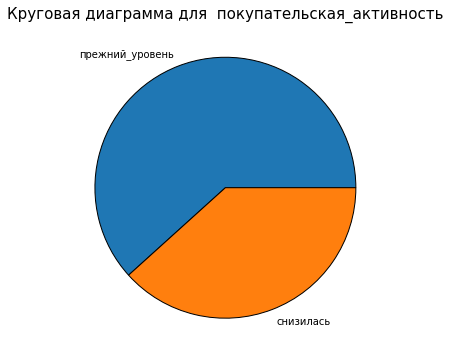

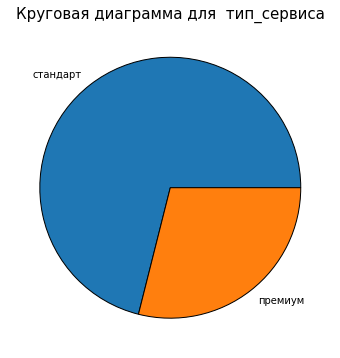

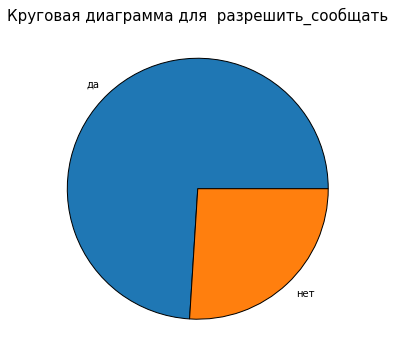

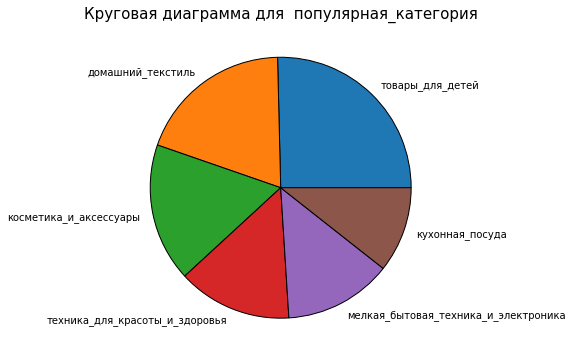

In [54]:
plot_category_feature(market_file,'покупательская_активность', pie_title_prefix\
                      ='Круговая диаграмма для ',
                     bar_title_prefix='Распределение для ',
                           xlabel_bar=None, ylabel_bar='Количество',
                           ylabel_boxplot=None),

plot_category_feature(market_file,'тип_сервиса', pie_title_prefix\
                      ='Круговая диаграмма для ',
                     bar_title_prefix='Распределение для ',
                           xlabel_bar=None, ylabel_bar='Количество',
                           ylabel_boxplot=None),
plot_category_feature(market_file,'разрешить_сообщать', pie_title_prefix\
                      ='Круговая диаграмма для ',
                     bar_title_prefix='Распределение для ',
                           xlabel_bar=None, ylabel_bar='Количество',
                           ylabel_boxplot=None),
plot_category_feature(market_file,'популярная_категория', pie_title_prefix\
                      ='Круговая диаграмма для ',
                     bar_title_prefix='Распределение для ',
                           xlabel_bar=None, ylabel_bar='Количество',
                           ylabel_boxplot=None)

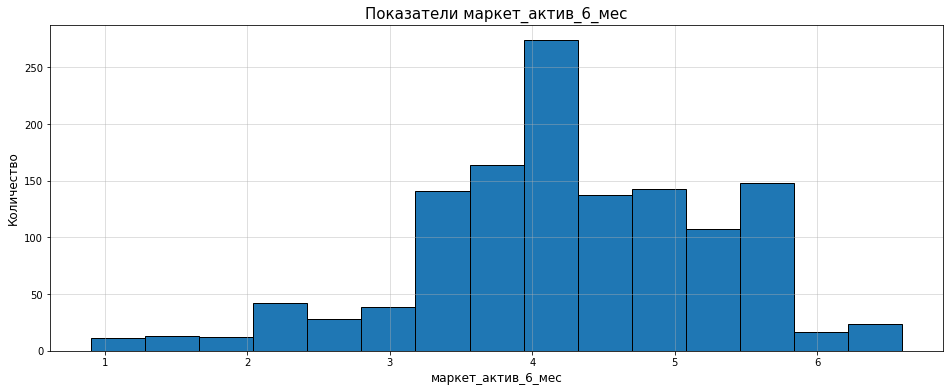

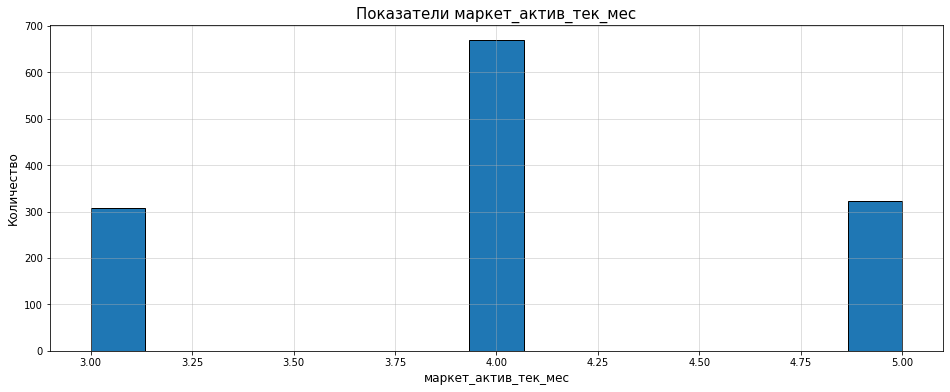

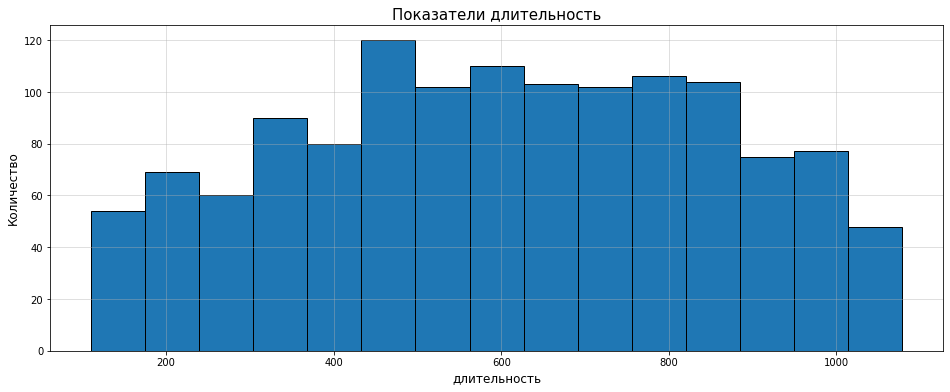

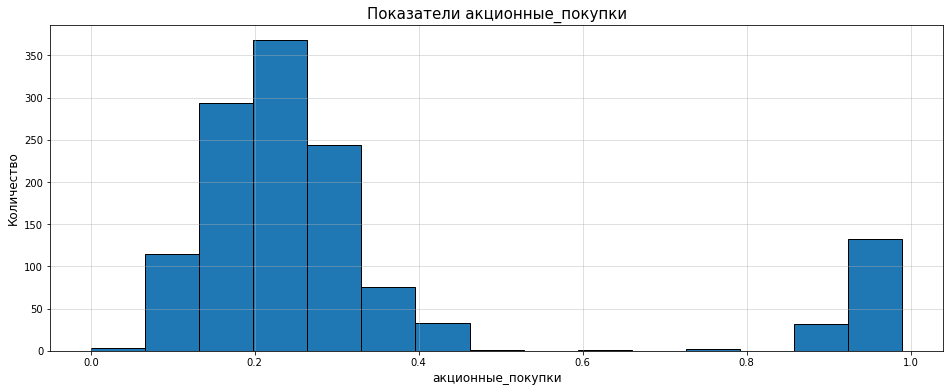

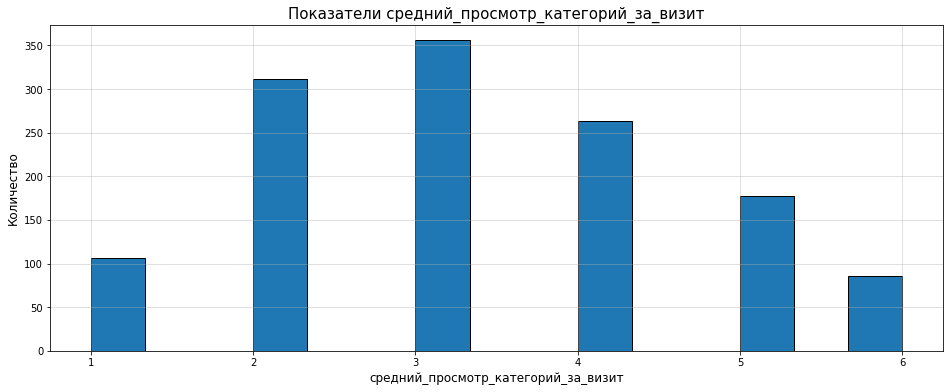

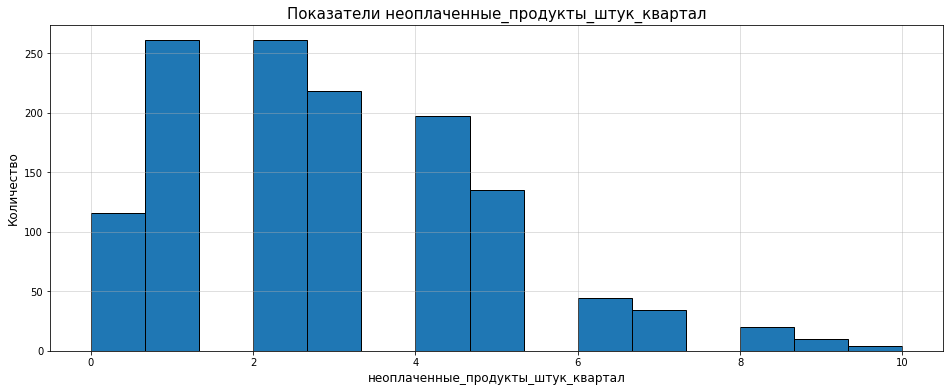

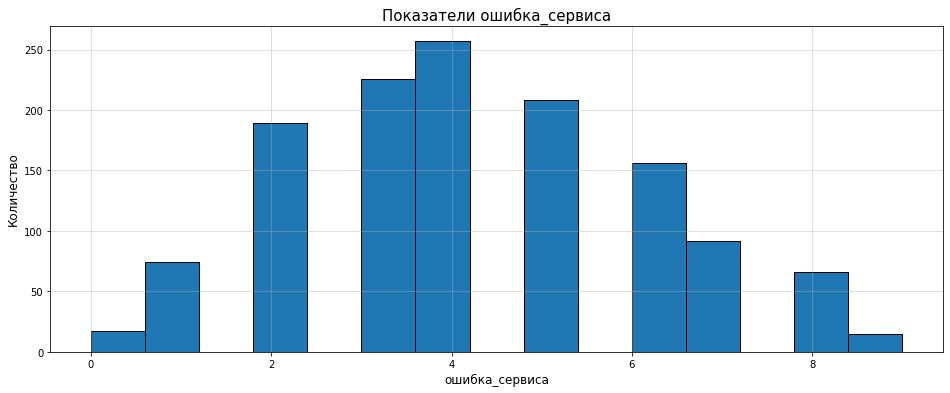

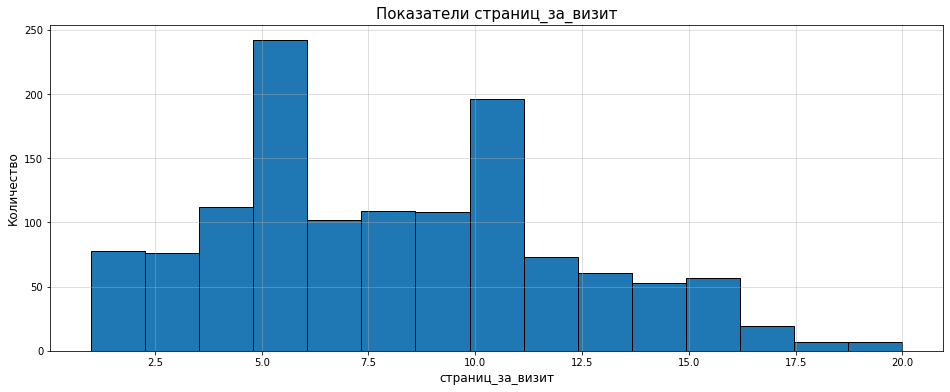

In [55]:
plot_numerical_feature(market_file, 'маркет_актив_6_мес',
                           hist_title_prefix='Показатели', 
                           boxplot_title_prefix='Гистограмма для',
                           xlabel_hist=None, ylabel_hist='Количество',
                           ylabel_boxplot=None),
plot_numerical_feature(market_file, 'маркет_актив_тек_мес',
                           hist_title_prefix='Показатели', 
                           boxplot_title_prefix='Гистограмма для',
                           xlabel_hist=None, ylabel_hist='Количество',
                           ylabel_boxplot=None),
plot_numerical_feature(market_file, 'длительность',
                           hist_title_prefix='Показатели', 
                           boxplot_title_prefix='Гистограмма для',
                           xlabel_hist=None, ylabel_hist='Количество',
                           ylabel_boxplot=None),
plot_numerical_feature(market_file, 'акционные_покупки',
                           hist_title_prefix='Показатели', 
                           boxplot_title_prefix='Гистограмма для',
                           xlabel_hist=None, ylabel_hist='Количество',
                           ylabel_boxplot=None),
plot_numerical_feature(market_file, 'средний_просмотр_категорий_за_визит',
                           hist_title_prefix='Показатели', 
                           boxplot_title_prefix='Гистограмма для',
                           xlabel_hist=None, ylabel_hist='Количество',
                           ylabel_boxplot=None),
plot_numerical_feature(market_file, 'неоплаченные_продукты_штук_квартал',
                           hist_title_prefix='Показатели', 
                           boxplot_title_prefix='Гистограмма для',
                           xlabel_hist=None, ylabel_hist='Количество',
                           ylabel_boxplot=None),
plot_numerical_feature(market_file, 'ошибка_сервиса',
                           hist_title_prefix='Показатели', 
                           boxplot_title_prefix='Гистограмма для',
                           xlabel_hist=None, ylabel_hist='Количество',
                           ylabel_boxplot=None),
plot_numerical_feature(market_file, 'страниц_за_визит',
                           hist_title_prefix='Показатели', 
                           boxplot_title_prefix='Гистограмма для',
                           xlabel_hist=None, ylabel_hist='Количество',
                           ylabel_boxplot=None)

Графики для market_money

(None,)

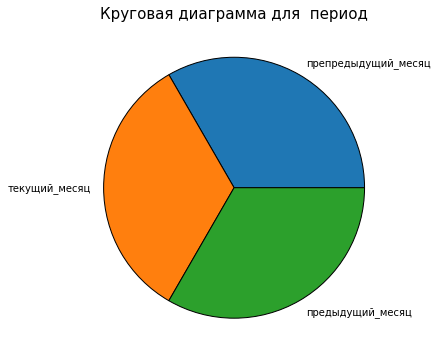

In [56]:
plot_category_feature(market_money,'период', pie_title_prefix\
                      ='Круговая диаграмма для ',
                     bar_title_prefix='Распределение для ',
                           xlabel_bar=None, ylabel_bar='Количество',
                           ylabel_boxplot=None),

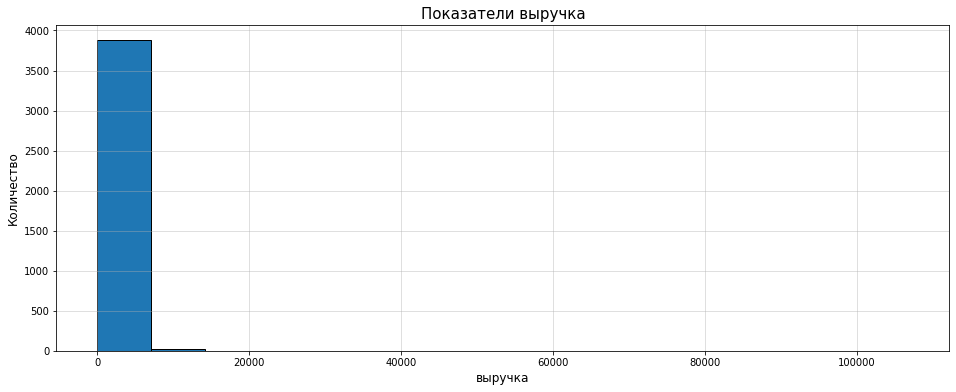

In [57]:
plot_numerical_feature(market_money, 'выручка',
                           hist_title_prefix='Показатели', 
                           boxplot_title_prefix='Гистограмма для',
                           xlabel_hist=None, ylabel_hist='Количество',
                           ylabel_boxplot=None)

In [58]:
market_money['выручка'].describe()

count     3,900.0
mean      5,025.7
std       1,777.7
min           0.0
25%       4,590.1
50%       4,957.5
75%       5,363.0
max     106,862.2
Name: выручка, dtype: float64

В данных о выручке обнаружен выброс, избавимся от него

In [59]:
market_money.isna().sum()

id         0
период     0
выручка    0
dtype: int64

In [60]:
market_money=market_money.query('0 < выручка < 20000')

In [61]:
market_money['выручка'].describe()

count   3,893.0
mean    5,007.3
std       679.7
min     2,758.7
25%     4,592.0
50%     4,959.0
75%     5,363.0
max     7,799.4
Name: выручка, dtype: float64

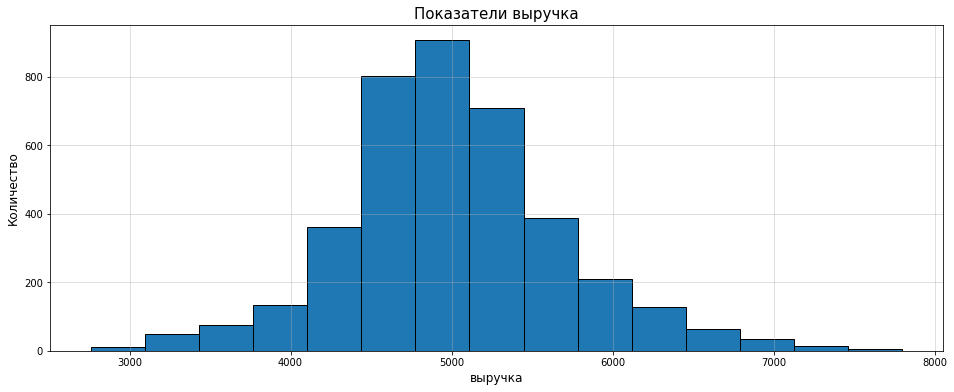

In [62]:
plot_numerical_feature(market_money, 'выручка',
                           hist_title_prefix='Показатели', 
                           boxplot_title_prefix='Гистограмма для',
                           xlabel_hist=None, ylabel_hist='Количество',
                           ylabel_boxplot=None)

Графики для market_time

In [63]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


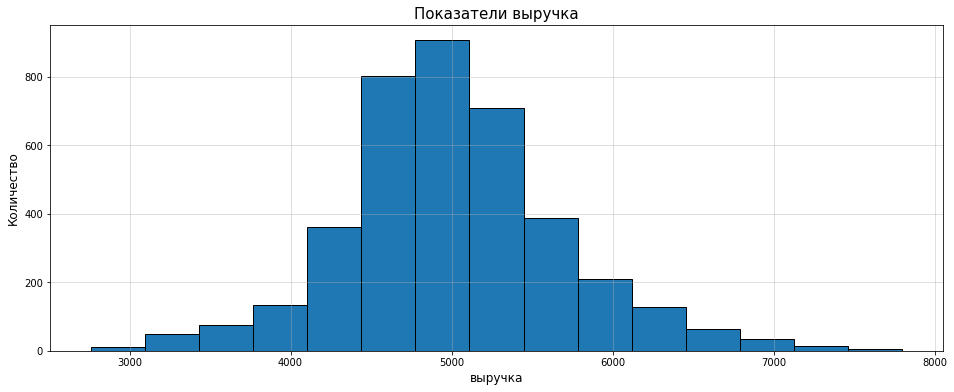

In [64]:
plot_numerical_feature(market_money, 'выручка',
                           hist_title_prefix='Показатели', 
                           boxplot_title_prefix='Гистограмма для',
                           xlabel_hist=None, ylabel_hist='Количество',
                           ylabel_boxplot=None)

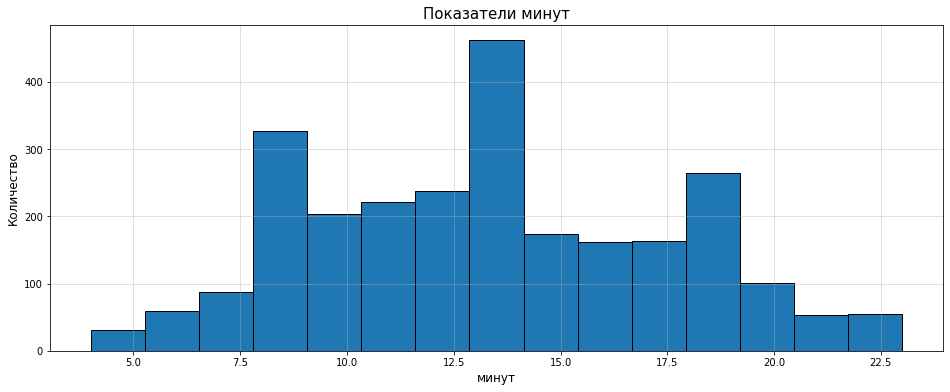

In [65]:
plot_numerical_feature(market_time, 'минут',
                           hist_title_prefix='Показатели', 
                           boxplot_title_prefix='Гистограмма для',
                           xlabel_hist=None, ylabel_hist='Количество',
                           ylabel_boxplot=None)

Графики для money

In [66]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


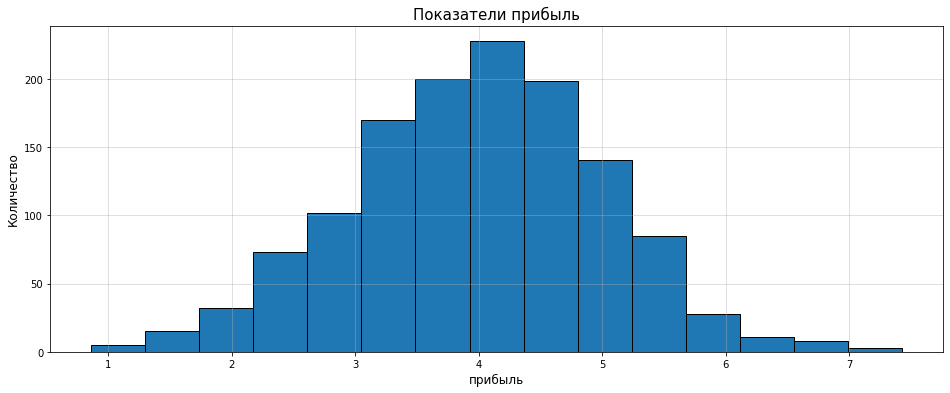

In [67]:
plot_numerical_feature(money, 'прибыль',
                           hist_title_prefix='Показатели', 
                           boxplot_title_prefix='Гистограмма для',
                           xlabel_hist=None, ylabel_hist='Количество',
                           ylabel_boxplot=None)

Отберем клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период. 
Сначала возьму df market_money и отсеку пользователей, которые вообще не принесли никакой выручки.Далее мне нужны только пользователи, которые в каждый из трех месяцов приносили выручку. Я предлагаю сгрупировать покупки по 'id' и перемножить выручку для каждого пользователя. Установив доп. условие с query таким образом я отсеку строки, где произведение равно 0 (те пользователь в какой-то из месяцев ничего не покупал).

In [68]:
market_money_active=market_money.groupby('id').prod().query('выручка != 0').reset_index()
market_money_active.head()

,id,выручка
0,215348,"3,293.1"
1,215349,"115,967,302,963.2"
2,215350,"133,227,608,068.0"
3,215351,"195,107,899,457.6"
4,215352,"156,676,273,987.5"


Сгруппирую market_money так, чтобы было видно, какая выручка от пользователя была в каждый период

In [69]:
market_money=market_money.query('id in @market_money_active.id')
market_money.head()

,id,период,выручка
1,215348,текущий_месяц,"3,293.1"
3,215349,препредыдущий_месяц,"4,472.0"
4,215349,текущий_месяц,"4,971.6"
5,215349,предыдущий_месяц,"5,216.0"
6,215350,препредыдущий_месяц,"4,826.0"


In [70]:
market_money['id'].value_counts()

215349    3
215756    3
215792    3
215790    3
215788    3
         ..
216209    3
215380    2
215359    1
215357    1
215348    1
Name: id, Length: 1300, dtype: int64

<u>Вывод:</u>    
Пользователей, которые делали покупки на протяжении трех месяцев или более - 1300.

## Объединение таблиц

Объединяем таблицы market_file, market_money, market_time. 

In [71]:
market_time_new=market_time.set_index(['id', 'период']).минут.unstack()#группируем таблицу, чтобы выделить периоды в столбцы
market_time_new=market_time_new.rename(columns={'предыдущий_месяц':'минуты_за _предыдущий_месяц', 'текущий_месяц':'минуты_за_текущий_месяц'})
#переименовывем столбцы

In [72]:
market_money_new=market_money.set_index(['id', 'период']).выручка.unstack()#группируем таблицу, чтобы выделить периоды в столбцы
market_money_new=market_money_new.rename(columns={'предыдущий_месяц':'выручка_за_предыдущий_месяц', 'препредыдущий_месяц':'выручка_за_препредыдущий_месяц', 'текущий_месяц':'выручка_за_текущий_месяц'})
#переименовывем столбцы

In [73]:
data_market=market_file.merge(market_time_new, on='id',how='outer')#объединяем таблицы
data_market=data_market.merge(market_money_new, on='id',how='outer')#объединяем таблицы

In [74]:
data_market.isna().sum()#проверяем на пропуски

id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
минуты_за _предыдущий_месяц            0
минуты_за_текущий_месяц                0
выручка_за_предыдущий_месяц            3
выручка_за_препредыдущий_месяц         3
выручка_за_текущий_месяц               1
dtype: int64

In [75]:
data_market.dropna(axis=0, inplace=True)
data_market.isna().sum()

id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
минуты_за _предыдущий_месяц            0
минуты_за_текущий_месяц                0
выручка_за_предыдущий_месяц            0
выручка_за_препредыдущий_месяц         0
выручка_за_текущий_месяц               0
dtype: int64

In [76]:
data_market.duplicated().sum()#проверяем на дубликаты

0

## Корреляционный анализ

Я проведу корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования. Сделаю выводы о мультиколлинеарности и при необходимости устраню её.

<AxesSubplot:>

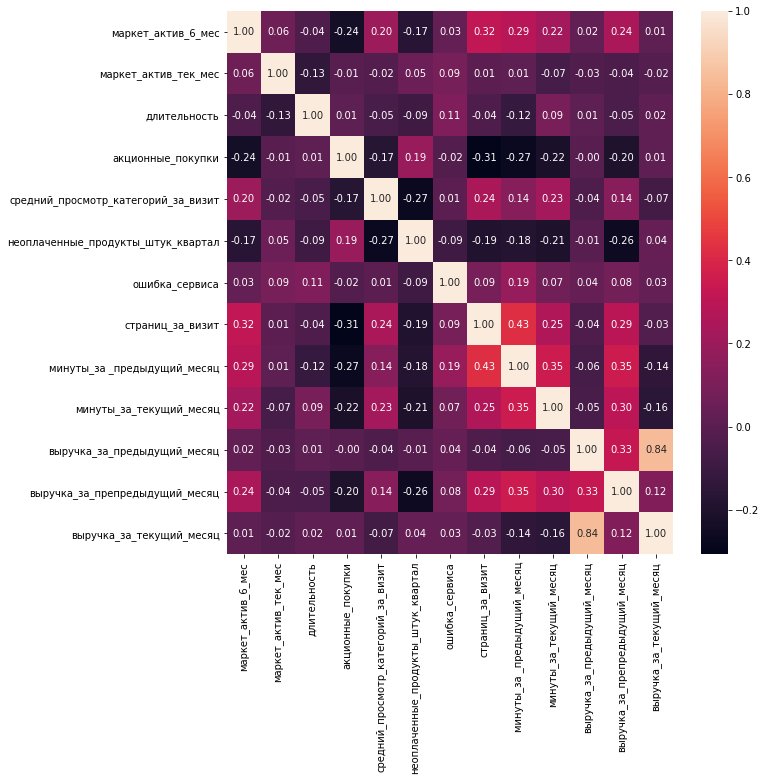

In [77]:
plt.figure(figsize=(10,10))
sns.heatmap((data_market.drop('id', axis=1)).corr(),annot=True, fmt='.2f')

Мультиколлинеарности не обнаружила

<AxesSubplot:>

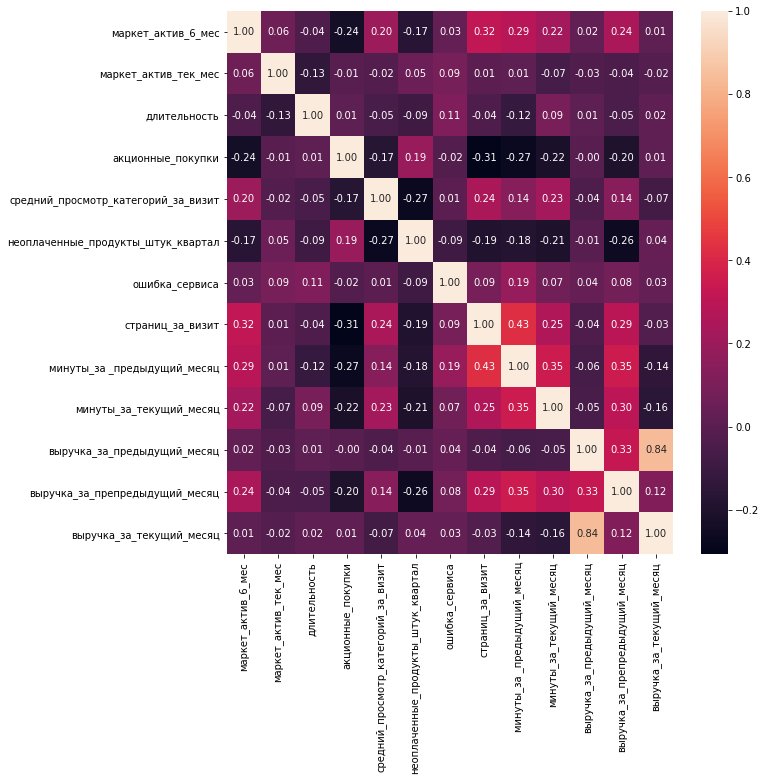

In [78]:
plt.figure(figsize=(10,10))
sns.heatmap((data_market.drop('id', axis=1)).corr(),annot=True, fmt='.2f')

## Использование пайплайнов

Это задача классификации, поэтому я выбираю метрику 'roc_auc', тк она устойчива к дисбалансу классов и легко интерпретируема

In [79]:
data_market.columns

Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит', 'минуты_за _предыдущий_месяц',
       'минуты_за_текущий_месяц', 'выручка_за_предыдущий_месяц',
       'выручка_за_препредыдущий_месяц', 'выручка_за_текущий_месяц'],
      dtype='object')

In [80]:
RANDOM_STATE=42
TEST_SIZE=0.25

X_train, X_test, y_train, y_test=train_test_split(data_market.drop(['покупательская_активность'], axis=1),
                                                  data_market['покупательская_активность'], random_state=RANDOM_STATE,
                                                  test_size=TEST_SIZE, stratify=data_market['покупательская_активность'])

X_train.shape, X_test.shape
                                                  
ohe_columns=['разрешить_сообщать','популярная_категория']
ord_columns=['тип_сервиса']                                                  
num_columns=['маркет_актив_6_мес','маркет_актив_тек_мес','длительность','акционные_покупки','средний_просмотр_категорий_за_визит',
             'неоплаченные_продукты_штук_квартал',
            'ошибка_сервиса','страниц_за_визит','минуты_за _предыдущий_месяц','минуты_за_текущий_месяц','выручка_за_предыдущий_месяц',
            'выручка_за_препредыдущий_месяц','выручка_за_текущий_месяц'] 
            
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe=Pipeline([('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                  #('ohe', OneHotEncoder(drop='first', handle_unknown='error',sparse_output=False))])
                   ('ohe', OneHotEncoder(drop='first', handle_unknown='error',sparse=False))]) 
 
                   
# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe=Pipeline([('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                  ('ord', OrdinalEncoder(categories=[['премиум','стандарт']], handle_unknown='use_encoded_value', 
                unknown_value=np.nan)), 
                   ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan,strategy='most_frequent'))])

num_pipe=Pipeline([('scaler',StandardScaler()),
                  ('poly', PolynomialFeatures(degree=2))])
data_preprocessor=ColumnTransformer([
                  ('ohe', ohe_pipe, ohe_columns),
                  ('ord', ord_pipe, ord_columns),                   
                  ('num', num_pipe, num_columns) ])

all_features = X_train.columns

# Затем создаем маску для категориальных признаков
categorical_mask = [True if col in ohe_columns + ord_columns else False 
                   for col in all_features]

smote = SMOTENC(categorical_features=categorical_mask, random_state=RANDOM_STATE)

pipe_final=ImbPipeline([
    
    ('preprocessor', data_preprocessor),
#     ('smote', SMOTENC(categorical_features=categorical_mask, random_state=RANDOM_STATE)), 
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,10),
        'models__max_features': range(2,10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    #{
        #'models': [LogisticRegression(
           # random_state=RANDOM_STATE, solver='saga'
       # )],
        #'models__C':[0.1, 1, 10, 100],
        #'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    #},
        
    {
        'models':[SVC(probability=True,random_state=RANDOM_STATE)],
        'models__C':[0.1, 1, 10, 100]
    }]



grid = GridSearchCV(
    pipe_final, 
    param_grid=param_grid, 
    cv=5, 
    scoring='roc_auc',
    n_jobs=-1, error_score='raise'
)
grid.fit(X_train, y_train) 

grid.best_estimator_, grid.best_score_

/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)
/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.

(Pipeline(steps=[('preprocessor',
                  ColumnTransformer(transformers=[('ohe',
                                                   Pipeline(steps=[('simpleImputer_ohe',
                                                                    SimpleImputer(strategy='most_frequent')),
                                                                   ('ohe',
                                                                    OneHotEncoder(drop='first',
                                                                                  sparse=False))]),
                                                   ['разрешить_сообщать',
                                                    'популярная_категория']),
                                                  ('ord',
                                                   Pipeline(steps=[('simpleImputer_before_ord',
                                                                    SimpleImputer(strategy='most_frequent')),
                      

In [81]:
pred=grid.best_estimator_.predict_proba(X_test)
score=roc_auc_score(y_test, pred[:,1])
score

0.9186587388261943

## Анализ важности признаков

У модели SVC нет параметра feature_importances, поэтому я буду использовать permutation_importances для оценки признаков

<AxesSubplot:ylabel='Feature'>

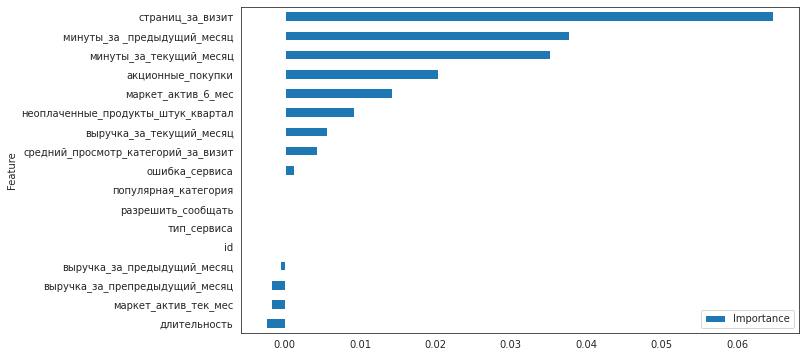

In [82]:
from sklearn.inspection import permutation_importance

best_model=grid.best_estimator_
perm_imp=permutation_importance(best_model, X_test, y_test)

features_names=X_test.columns

feature_importance = pd.DataFrame({'Feature': features_names, 'Importance': perm_imp['importances_mean']})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
sns.set_style('white')
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6)) 

Как мы видим, меньше всего для модели значат признаки: разрешить сообщать, тип_сервиса и длительность

Теперь нам предстоит создать график важности с помощью метода SHAP

In [83]:
scaler = StandardScaler()
ordin=OrdinalEncoder(categories=[['премиум','стандарт']], handle_unknown='use_encoded_value',unknown_value=np.nan)
poly=PolynomialFeatures(degree=2)
#ohe=OneHotEncoder(drop='first', handle_unknown='error',sparse_output=False)
ohe=OneHotEncoder(drop='first', handle_unknown='error',sparse=False)

X_train, X_test, y_train, y_test = train_test_split(
    data_market.drop(['покупательская_активность'], axis=1),
    data_market['покупательская_активность'], 
    random_state=RANDOM_STATE,
    test_size=TEST_SIZE, 
    stratify=data_market['покупательская_активность']
)

                                                  
ohe_columns=['разрешить_сообщать','популярная_категория']
ord_columns=['тип_сервиса']                                                  
num_columns=['маркет_актив_6_мес','маркет_актив_тек_мес','длительность','акционные_покупки','средний_просмотр_категорий_за_визит',
             'неоплаченные_продукты_штук_квартал',
            'ошибка_сервиса','страниц_за_визит','минуты_за _предыдущий_месяц','минуты_за_текущий_месяц','выручка_за_предыдущий_месяц',
            'выручка_за_препредыдущий_месяц','выручка_за_текущий_месяц']


# Преобразования для разных типов признаков
X_train_scaled = scaler.fit_transform(X_train[num_columns])
X_test_scaled = scaler.transform(X_test[num_columns])

X_train_ord = ordin.fit_transform(X_train[ord_columns])
X_test_ord = ordin.transform(X_test[ord_columns])

X_train_ohe = ohe.fit_transform(X_train[ohe_columns])
X_test_ohe = ohe.transform(X_test[ohe_columns])

# Объединение всех признаков
X_train_processed = np.concatenate([X_train_ohe, X_train_scaled, X_train_ord], axis=1)
X_test_processed = np.concatenate([X_test_ohe, X_test_scaled, X_test_ord], axis=1)

# Теперь можно применить PolynomialFeatures к уже обработанным числовым данным
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_processed)
X_test_poly = poly.transform(X_test_processed)

# Обучение модели
clf = SVC(C=1, probability=True)
clf.fit(X_train_poly, y_train)
best_model_2 = clf.predict(X_test_poly)

In [84]:
f = lambda x: grid.predict_proba(
    pd.DataFrame(x, columns=X_train.columns)
)

  0%|          | 0/50 [00:00<?, ?it/s]

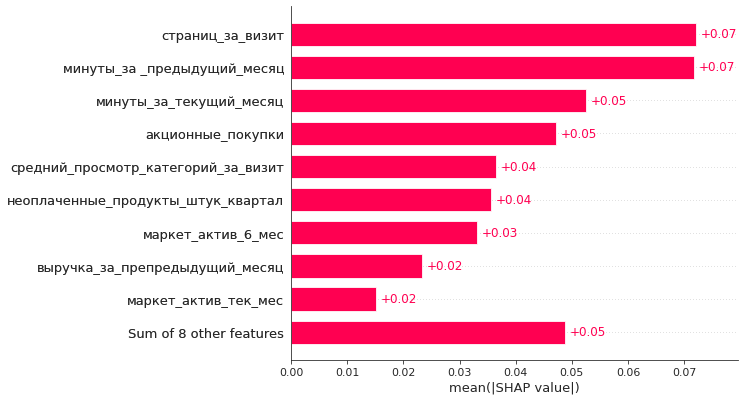

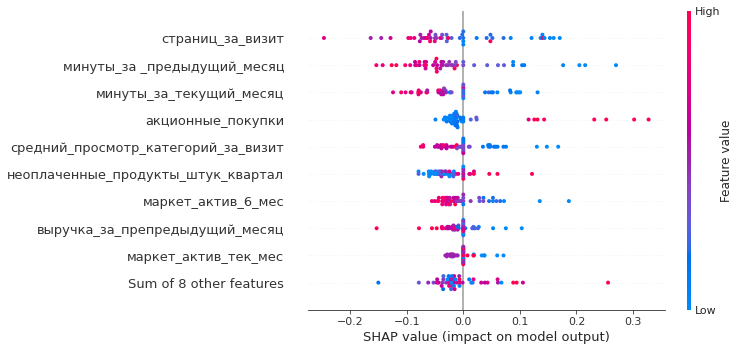

In [85]:
explainer = shap.KernelExplainer(f, X_train[:50])
shap_values = explainer(X_test[:50])
shap.plots.bar(shap_values[:,:,1])
shap.plots.beeswarm(shap_values[:,:,1]) 

__Какие признаки мало значимы для модели:__    
-Разрешить сообщать нет  
-популярная категория товары для детей   
-популярная категория кухонная посуда  
  
__Какие признаки сильнее всего влияют на целевой признак:__  
-минуты за предыдущий месяц  
-акционные покупки  
-средний просмотр категорий за визит  
  
__Как можно использовать эти наблюдения при моделировании и принятии бизнес-решений:__  
-Увеличивать акции  
-Добавить интерактив на сайте для пользователей, возможно, рекламу или предложения перед финальной покупкой, основываясь на его прошлых покупках за квартал, к примеру  
-Рекомендовать пользователю товары из категории, которая может относиться к его. К примеру, он смотрит кухонную посуду, а в товарах для детей есть воротничок или доп.товары к детской посуде.

## Сегментация покупателей

На всякий случай, объединю четвертую таблицу с той, которую использовала в модели

In [86]:
all_data=data_market.merge(money, on='id',how='left')
all_data.tail()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минуты_за _предыдущий_месяц,минуты_за_текущий_месяц,выручка_за_предыдущий_месяц,выручка_за_препредыдущий_месяц,выручка_за_текущий_месяц,прибыль
1291,216643,прежний_уровень,стандарт,да,6.6,3,318,0.2,техника_для_красоты_и_здоровья,5,3,3,11,14,7,"3,664.0","4,704.0","4,741.7",4.4
1292,216644,прежний_уровень,стандарт,нет,5.1,4,454,0.2,домашний_текстиль,6,2,3,9,12,11,"4,729.0","5,299.0","5,353.0",6.1
1293,216645,прежний_уровень,стандарт,да,4.1,3,586,0.2,домашний_текстиль,3,2,5,7,12,18,"5,160.0","5,334.0","5,139.2",3.3
1294,216646,прежний_уровень,стандарт,да,6.3,5,645,0.1,техника_для_красоты_и_здоровья,3,3,5,7,18,7,"4,923.0","4,725.0","5,224.6",4.0
1295,216647,прежний_уровень,премиум,да,4.0,5,906,0.9,техника_для_красоты_и_здоровья,4,5,3,12,15,10,"4,720.0","5,183.0","4,448.3",3.3


Строим матрицу, включащую категориальные и числовые признаки

interval columns not set, guessing: ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'минуты_за _предыдущий_месяц', 'минуты_за_текущий_месяц', 'выручка_за_предыдущий_месяц', 'выручка_за_препредыдущий_месяц', 'выручка_за_текущий_месяц', 'прибыль']


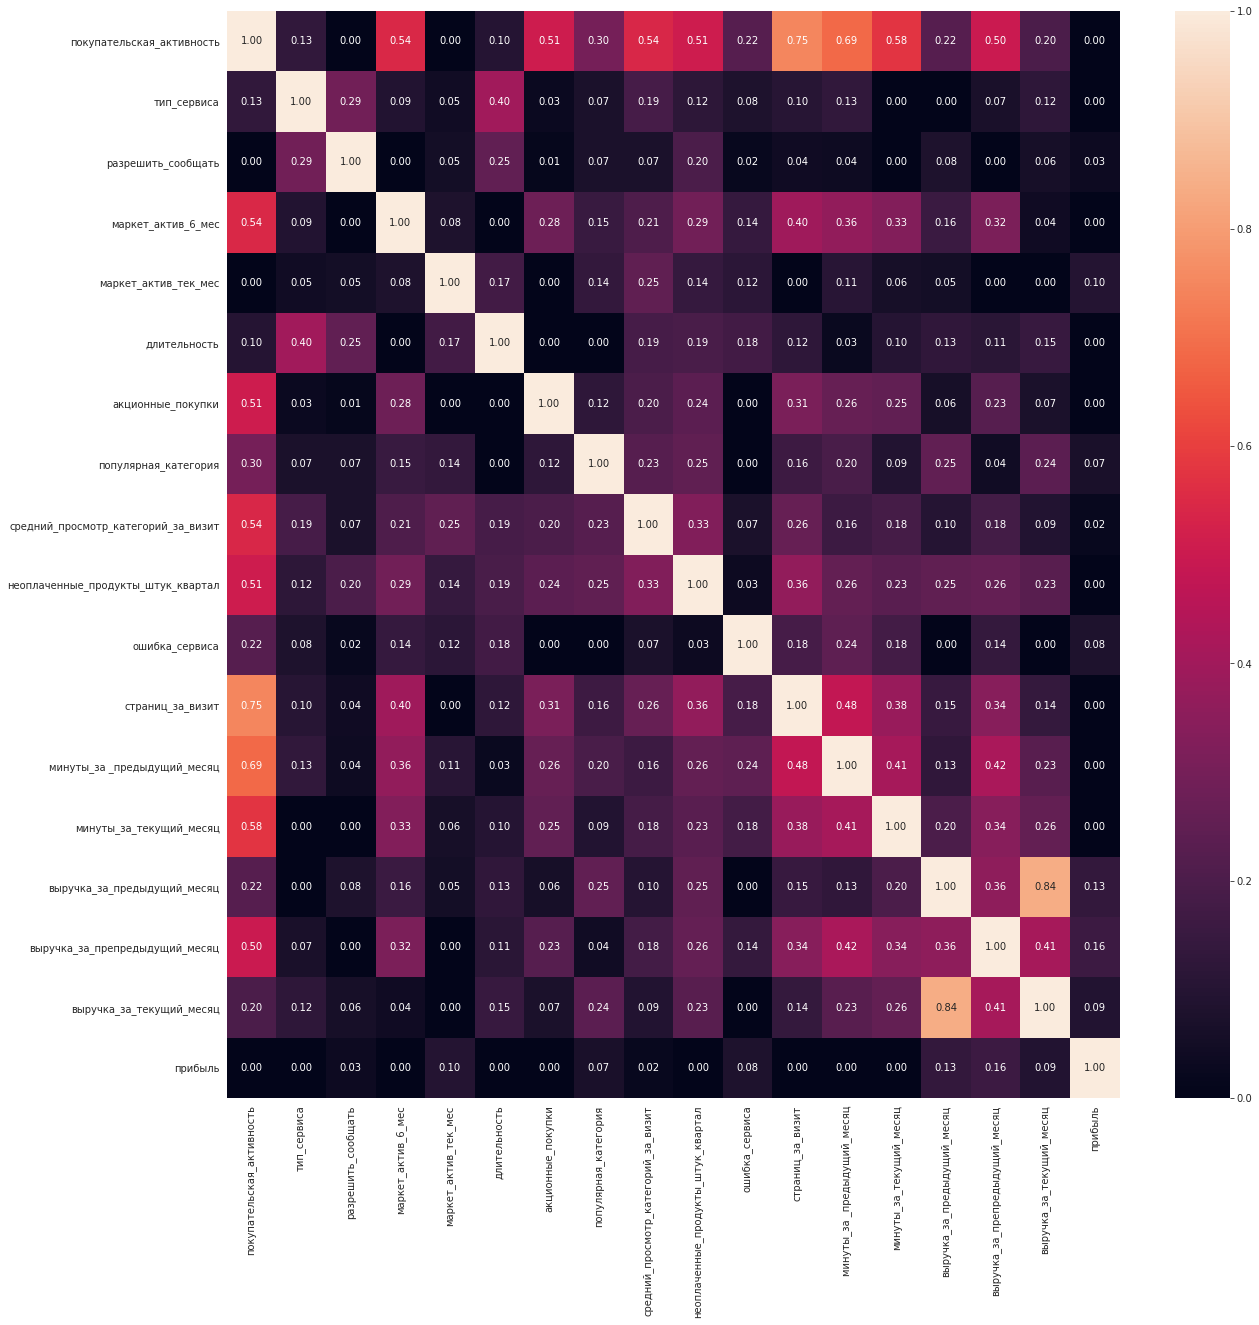

In [87]:
plt.figure(figsize=(20,20))
sns.heatmap(all_data.drop('id', axis=1).phik_matrix(),annot=True, fmt='.2f')
plt.show()

__Согласно матрице покупательская активность сильно сопряжена с__:    

-маркет_актив_6_мес  
-акционные_покупки  
-средний_просмотр_категорий_за_визит  
-неоплаченные_продукты_штук_квартал  
-страниц_за_визит  
-минуты_за _предыдущий_месяц  
-выручка_за_препредыдущий_месяц  
  
__Самая сильная корреляция:__  

-страниц_за_визит(0.75)  
-минуты_за _предыдущий_месяц(0.69)  
-маркет_актив_6_мес(0.54)

In [88]:
#вероятность снижения покупательской активности
all_data['вероятность_снижения']=best_model.predict_proba(all_data.drop(['покупательская_активность','прибыль'], axis=1))[:,1]
all_data.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минуты_за _предыдущий_месяц,минуты_за_текущий_месяц,выручка_за_предыдущий_месяц,выручка_за_препредыдущий_месяц,выручка_за_текущий_месяц,прибыль,вероятность_снижения
0,215349,снизилась,премиум,да,4.4,4,819,0.8,товары_для_детей,4,4,2,5,12,10,"5,216.0","4,472.0","4,971.6",4.2,1.0
1,215350,снизилась,стандарт,нет,4.9,3,539,0.1,домашний_текстиль,5,2,1,5,8,13,"5,457.5","4,826.0","5,058.4",3.1,0.4
2,215351,снизилась,стандарт,да,3.2,5,896,1.0,товары_для_детей,5,0,6,4,11,13,"6,158.0","4,793.0","6,610.4",4.9,0.8
3,215352,снизилась,стандарт,нет,5.1,3,1064,0.9,товары_для_детей,3,2,3,2,8,11,"5,807.5","4,594.0","5,872.5",4.2,1.0
4,215353,снизилась,стандарт,да,3.3,4,762,0.3,домашний_текстиль,4,1,1,4,10,10,"4,738.5","5,124.0","5,388.5",4.0,0.8


In [89]:
# Создаем копию данных 
all_data_new = all_data.copy()

# Создаем булеву маску для фильтрации
mask = (
    (all_data_new['популярная_категория'] == "техника_для_красоты_и_здоровья") | 
    (all_data_new['популярная_категория'] == "мелкая_бытовая_техника_и_электроника")
)

# Добавляем новый столбец с результатом
all_data_new['покупают_технику'] = mask

# Удаляем столбец
all_data_new_2= all_data_new.drop('популярная_категория', axis=1)
all_data_new_2=all_data_new_2.query('покупают_технику==True')
all_data_new.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,...,ошибка_сервиса,страниц_за_визит,минуты_за _предыдущий_месяц,минуты_за_текущий_месяц,выручка_за_предыдущий_месяц,выручка_за_препредыдущий_месяц,выручка_за_текущий_месяц,прибыль,вероятность_снижения,покупают_технику
0,215349,снизилась,премиум,да,4.4,4,819,0.8,товары_для_детей,4,...,2,5,12,10,"5,216.0","4,472.0","4,971.6",4.2,1.0,False
1,215350,снизилась,стандарт,нет,4.9,3,539,0.1,домашний_текстиль,5,...,1,5,8,13,"5,457.5","4,826.0","5,058.4",3.1,0.4,False
2,215351,снизилась,стандарт,да,3.2,5,896,1.0,товары_для_детей,5,...,6,4,11,13,"6,158.0","4,793.0","6,610.4",4.9,0.8,False
3,215352,снизилась,стандарт,нет,5.1,3,1064,0.9,товары_для_детей,3,...,3,2,8,11,"5,807.5","4,594.0","5,872.5",4.2,1.0,False
4,215353,снизилась,стандарт,да,3.3,4,762,0.3,домашний_текстиль,4,...,1,4,10,10,"4,738.5","5,124.0","5,388.5",4.0,0.8,False


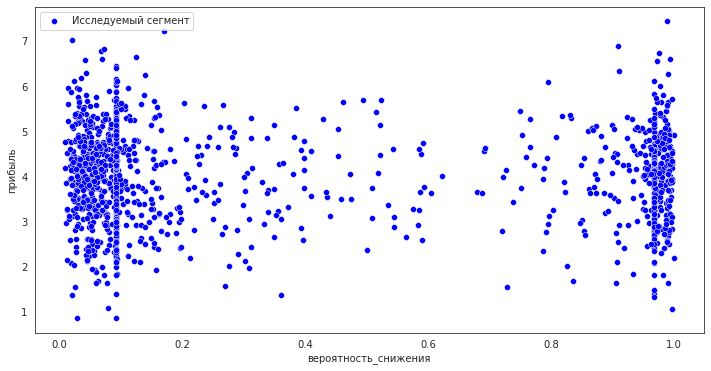

In [90]:
plt.figure(figsize=(12,6))

sns.scatterplot(data=all_data_new, x='вероятность_снижения', y='прибыль', label='Исследуемый сегмент', color='blue') 
plt.legend()
plt.show()

In [91]:
data_seg = all_data_new[(all_data_new['вероятность_снижения'] > 0.8) &(all_data_new['прибыль'] > 2)]
data_seg.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,...,ошибка_сервиса,страниц_за_визит,минуты_за _предыдущий_месяц,минуты_за_текущий_месяц,выручка_за_предыдущий_месяц,выручка_за_препредыдущий_месяц,выручка_за_текущий_месяц,прибыль,вероятность_снижения,покупают_технику
0,215349,снизилась,премиум,да,4.4,4,819,0.8,товары_для_детей,4,...,2,5,12,10,"5,216.0","4,472.0","4,971.6",4.2,1.0,False
2,215351,снизилась,стандарт,да,3.2,5,896,1.0,товары_для_детей,5,...,6,4,11,13,"6,158.0","4,793.0","6,610.4",4.9,0.8,False
3,215352,снизилась,стандарт,нет,5.1,3,1064,0.9,товары_для_детей,3,...,3,2,8,11,"5,807.5","4,594.0","5,872.5",4.2,1.0,False
5,215354,снизилась,стандарт,да,5.1,3,431,0.2,косметика_и_аксессуары,2,...,7,2,11,12,"5,685.0","4,503.0","5,869.6",3.6,0.9,False
7,215356,снизилась,стандарт,да,4.2,4,192,0.1,косметика_и_аксессуары,2,...,1,3,6,7,"4,146.5","4,433.0","4,566.4",4.9,1.0,False


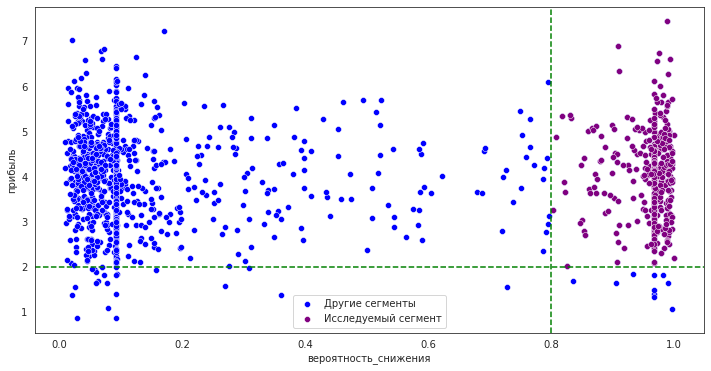

In [92]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=all_data_new, x='вероятность_снижения', y='прибыль', label='Другие сегменты', color='blue')
sns.scatterplot(data=data_seg, x='вероятность_снижения', y='прибыль', label='Исследуемый сегмент', color='purple')  
plt.legend()
plt.axvline(x=0.8,color='green', linestyle='--')
plt.axhline(y=2,color='green', linestyle='--')
plt.show()

Я выбрала группу, которая покупает различную технику, сейчас мы подробнее рассмотрим её на фоне сегмента

In [93]:
mask = (
    (all_data_new['популярная_категория'] == "техника_для_красоты_и_здоровья") | 
    (all_data_new['популярная_категория'] == "мелкая_бытовая_техника_и_электроника")
)

# Добавляем новый столбец с результатом
data_seg['покупают_технику'] = mask

# Удаляем столбец
data_tech= data_seg.drop('популярная_категория', axis=1)
data_tech= data_tech.query('покупают_технику==True')
data_tech.head()

/tmp/ipykernel_484/367456600.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_seg['покупают_технику'] = mask


,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минуты_за _предыдущий_месяц,минуты_за_текущий_месяц,выручка_за_предыдущий_месяц,выручка_за_препредыдущий_месяц,выручка_за_текущий_месяц,прибыль,вероятность_снижения,покупают_технику
10,215361,снизилась,стандарт,да,5.1,4,199,0.2,4,5,2,3,11,13,"6,400.0","4,597.0","3,789.7",4.0,1.0,True
14,215365,снизилась,стандарт,да,3.9,4,167,0.9,6,4,2,5,6,10,"4,577.0","4,190.0","4,799.3",3.6,0.8,True
17,215368,снизилась,премиум,да,3.8,5,829,0.2,2,2,6,1,11,9,"5,823.0","4,536.0","5,591.6",6.3,1.0,True
27,215378,снизилась,стандарт,да,1.7,3,488,0.4,5,1,4,3,12,8,"3,543.0","4,302.0","4,364.6",3.0,0.9,True
30,215382,снизилась,стандарт,да,4.6,4,330,0.9,6,2,7,6,15,8,"5,545.5","4,824.0","6,403.5",2.4,0.9,True


/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable покупают_технику for analysis 1. Dropping this column
  warnings.warn(


interval columns not set, guessing: ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'минуты_за _предыдущий_месяц', 'минуты_за_текущий_месяц', 'выручка_за_предыдущий_месяц', 'выручка_за_препредыдущий_месяц', 'выручка_за_текущий_месяц', 'прибыль', 'вероятность_снижения']


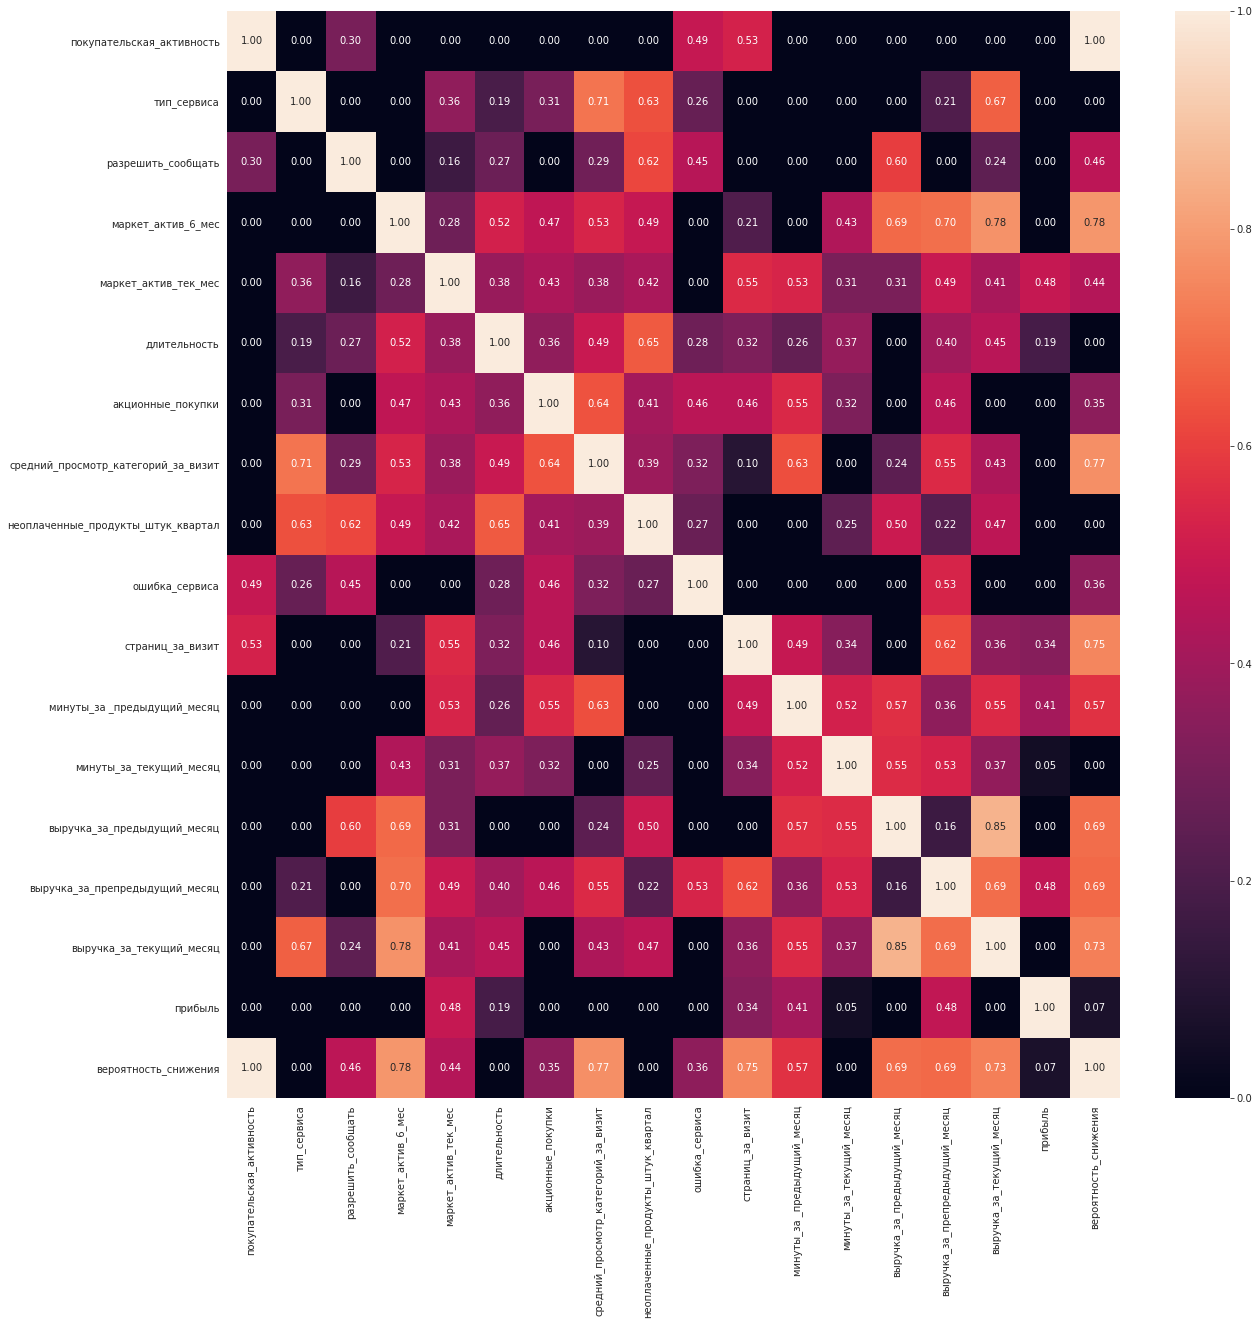

In [94]:
plt.figure(figsize=(20,20))
sns.heatmap(data_tech.drop('id', axis=1).phik_matrix(), annot=True, fmt='.2f')
plt.show()

__На вероятность снижения сильнее всего влияют:__    

-'выручка_за_текущий_месяц'  
-'страниц_за_визит'   
-'выручка_за_предыдущий_месяц'

__На покупательскую активность сильнее всего влияют:__  

-'разрешить_сообщать'  
-'страниц_за_визит'  
-'ошибка_сервиса'

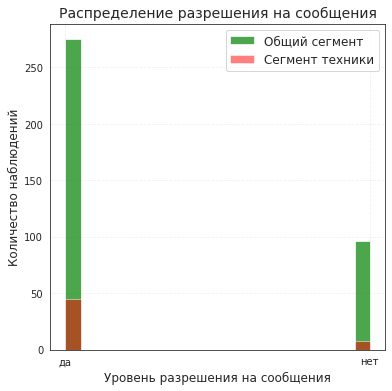

In [95]:
plt.figure(figsize=(6, 6))

# Гистограмма для data_seg
plt.hist(data_seg['разрешить_сообщать'], 
         bins=20, 
         color='green', 
         alpha=0.7, 
         label='Общий сегмент')

# Гистограмма для data_tech
plt.hist(data_tech['разрешить_сообщать'], 
         bins=20, 
         color='red', 
         alpha=0.5, 
         label='Сегмент техники')

# Настройки графика
plt.title('Распределение разрешения на сообщения', fontsize=14)
plt.xlabel('Уровень разрешения на сообщения', fontsize=12)
plt.ylabel('Количество наблюдений', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)

plt.show()

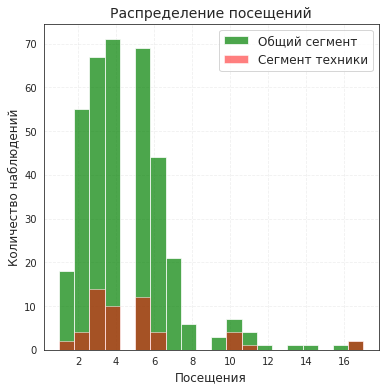

In [96]:
plt.figure(figsize=(6, 6))

# Гистограмма для data_seg
plt.hist(data_seg['страниц_за_визит'], 
         bins=20, 
         color='green', 
         alpha=0.7, 
         label='Общий сегмент')

# Гистограмма для data_tech
plt.hist(data_tech['страниц_за_визит'], 
         bins=20, 
         color='red', 
         alpha=0.5, 
         label='Сегмент техники')

# Настройки графика
plt.title('Распределение посещений', fontsize=14)
plt.xlabel('Посещения', fontsize=12)
plt.ylabel('Количество наблюдений', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)

plt.show()

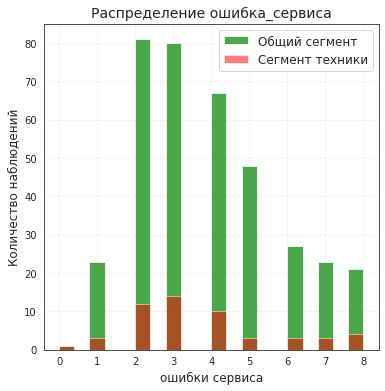

In [97]:
plt.figure(figsize=(6, 6))

# Гистограмма для data_seg
plt.hist(data_seg['ошибка_сервиса'], 
         bins=20, 
         color='green', 
         alpha=0.7, 
         label='Общий сегмент')

# Гистограмма для data_tech
plt.hist(data_tech['ошибка_сервиса'], 
         bins=20, 
         color='red', 
         alpha=0.5, 
         label='Сегмент техники')

# Настройки графика
plt.title('Распределение ошибка_сервиса', fontsize=14)
plt.xlabel('ошибки сервиса', fontsize=12)
plt.ylabel('Количество наблюдений', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

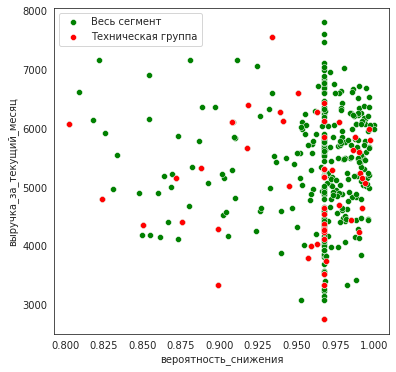

In [98]:
plt.figure(figsize=(6,6))
sns.scatterplot(data=data_seg, x='вероятность_снижения', y='выручка_за_текущий_месяц', label='Весь сегмент', color='green')
sns.scatterplot(data=data_tech, x='вероятность_снижения', y='выручка_за_текущий_месяц', label='Техническая группа', color='red')  
plt.legend()
plt.show()

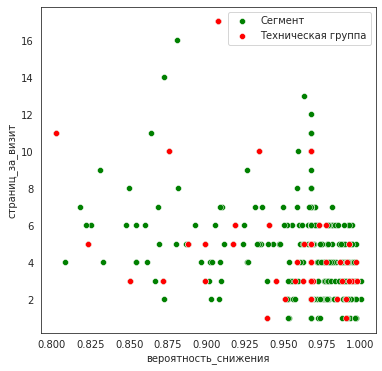

In [99]:
plt.figure(figsize=(6,6))
sns.scatterplot(data=data_seg, x='вероятность_снижения', y='страниц_за_визит', label='Сегмент', color='green')
sns.scatterplot(data=data_tech, x='вероятность_снижения', y='страниц_за_визит', label='Техническая группа', color='red')  
plt.legend()
plt.show()

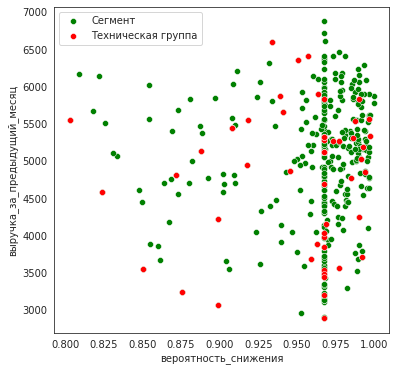

In [100]:
plt.figure(figsize=(6,6))
sns.scatterplot(data=data_seg, x='вероятность_снижения', y='выручка_за_предыдущий_месяц', label='Сегмент', color='green')
sns.scatterplot(data=data_tech, x='вероятность_снижения', y='выручка_за_предыдущий_месяц', label='Техническая группа', color='red')  
plt.legend()
plt.show()

__Анализ__:  

-разрешить_сообщать  
1:6 разрешают сообщать о доп.предложениях, а 1:5 нет
Это объясняется тем, что техника служит дольше чем посуда или другие товары, а значит, после покупки на пользователя негативно влияет рассылка

-страниц_за_визит  
Относительно других секций техническая группа более равномерно просматривает страницы, многие доходят до последних
Так происходит потому, что техника выбирается тщательнее остальных товаров, тк она дороже и выбирается на долгие годы  

Вероятность снижения тут зависит от меньшего кол-ва страниц, до 7,5, после этого она падает


-ошибки_сервиса  
Забавно, но они тоже распределны достаточно равномерно в оличчае от других сегментов. Это говорит о том, что ошибок сервиса этому сегменту претерпевать приходится больше

-выручка_за_текущий_месяц  
Вероятность снижения выручки линией выделяется - 0.925, это плохо. Достаточно высока вероятность, когда достаточно много пользователей могли принести выручку от низких до высоких значений. Однако, основной сегмент всё же опережает по этому показателю

-выручка_за_предыдущий_месяц  
Вероятность снижения выручки линией также выделяется - 0.925, это плохо. Достаточно высока вероятность, когда достаточно много пользователей могли принести выручку от низких до высоких значений. Однако, основной сегмент всё же опережает по этому показателю

__Предложения:__    

1)Следует настроить алгоритм, чтобы сократить число рассылок на пользователей, ранее купивших технику. Это перестанет создавать им триггер и внимание сфокусируется на предложении, а не на теме сообщения.
  
2)Нужно сделать всё, чтобы удерживать пользователей на странице как можно дольше. Для этого можно сделать сплошную ленту товаров, что не будет отвлекать их, чтобы перелистнуьт и надолго затянет в поиске того самого. 
  
3)Больше всего внимания надо обратить на ошибки сервиса. Покупателей техники они касаются чаще остальных, возможно, нужно настроить работу сайта в автономном режиме на время ошибок. Допустим, не будут появляться новые товары, или е будет рекламы, но пользователь должен иметь проход к товарам.  
  
4)Показатели снижения вероятности за оба месяца не сильно радуют. Если справить вышеперечисленные моменты, можно ждать их улучения.

## Общий вывод

<u>1) Описание задачи</u>  

Отчёт магазина «В один клик» за прошлый период показал, что активность покупателей начала снижаться. Возможный выход — удерживать активность постоянных клиентов, сделать это можно с помощью персонализированных предложений. Отделу цифровых технологий (в котором я стажер) поручили разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.
Моя задача - выбрать лучшую модель после обучения, а также метрику оценки к ней и её гиперпараметры. Реализовать решение, предоставленное руководством.

<u>2) Описание исходных данных и проведенной предобработки</u> 

Исходные данные:

    *Столбцы необходимо привести к змеиному коду
    *Не все типы данных соотвествуют данным
    *Некоторые значения надо скорректировать, они были введены некорректно
    *Все данные соответствуют описанию

Предобработка:  

    *Все названия столбцов были приведены к змеиному коду и нижнему регистру  
    *Установлены корректные типы данных  
    *Корректировка неявных дубликатов
    *Отсутсвие пропусков и явных дубликатов  
  
<u>3) Проделанная работа для поиска лучшей модели:</u> 

    *Сформирована общая таблица, которая учитывает активных полльзователей  
    *Проведен корреляционный анализ признаков, выявлена и устранена утечка данных  
    *Выбрана метрица 'roc_auc' для задачи классификации  
    *Подготовка данных с методом ColumnTransformer    
    *Создание пайплайнов для обучения 4х моделей:KNeighborsClassifier(),DecisionTreeClassifier(),LogisticRegression(),SVC()  
    *Для каждой модели подобраны гиперпараметры    
   
<u>4) Лучшая модель:</u>  
(C=1, probability=True, random_state=42)

    *Результат на тренировочных данных:0.94
    *Результат на тестовых данных:0.92  
  
<u>5) Выводы и предложения:</u>  
Прибыльность клиентов действительно сильно снизилась по сравнению с прежним уровнем.  
Согласно матрице покупательская активность сильно сопряжена с:  

    *страниц_за_визит(0.75)
    *минуты_за _предыдущий_месяц(0.69)
    *маркет_актив_6_мес(0.55)   

Я рассмотрела сегмент клиентов, которые покупают только технику, то есть товары с длинным жизненным циклом.  
Отфильтровала таких клиентов  

На _вероятность снижения_ сильнее всего влияют:

    *'выручка_за_текущий_месяц'
    *'страниц_за_визит'
    *'выручка_за_предыдущий_месяц'

На _покупательскую активность_ сильнее всего влияют:

    *'разрешить_сообщать'
    *'страниц_за_визит'
    *'ошибка_сервиса'
  

Заметно очень сильное снижение покупательской активности, сегмент надо проработать.    
  
_Анализ:_
  
    * разрешить_сообщать  
1:6 разрешают сообщать о доп.предложениях, а 1:5 нет
Это объясняется тем, что техника служит дольше чем посуда или другие товары, а значит, после покупки на пользователя негативно влияет рассылка

    * страниц_за_визит  
Относительно других секций техническая группа более равномерно просматривает страницы, многие доходят до последних
Так происходит потому, что техника выбирается тщательнее остальных товаров, тк она дороже и выбирается на долгие годы  

Вероятность снижения тут зависит от меньшего кол-ва страниц, до 7,5, после этого она падает


    * ошибки_сервиса  
Забавно, но они тоже распределны достаточно равномерно в оличчае от других сегментов. Это говорит о том, что ошибок сервиса этому сегменту претерпевать приходится больше

    *выручка_за_текущий_месяц  
Вероятность снижения выручки линией выделяется - 0.925, это плохо. Достаточно высока вероятность, когда достаточно много пользователей могли принести выручку от низких до высоких значений. Однако, основной сегмент всё же опережает по этому показателю

    *выручка_за_предыдущий_месяц  
Вероятность снижения выручки линией также выделяется - 0.925, это плохо. Достаточно высока вероятность, когда достаточно много пользователей могли принести выручку от низких до высоких значений. Однако, основной сегмент всё же опережает по этому показателю

_Предложения:_

    1) Следует настроить алгоритм, чтобы сократить число рассылок на пользователей, ранее купивших технику. Это перестанет создавать им триггер и внимание сфокусируется на предложении, а не на теме сообщения.
  
    2) Нужно сделать всё, чтобы удерживать пользователей на странице как можно дольше. Для этого можно сделать сплошную ленту товаров, что не будет отвлекать их, чтобы перелистнуьт и надолго затянет в поиске того самого. 
  
    3) Больше всего внимания надо обратить на ошибки сервиса. Покупателей техники они касаются чаще остальных, возможно, нужно настроить работу сайта в автономном режиме на время ошибок. Допустим, не будут появляться новые товары, или е будет рекламы, но пользователь должен иметь проход к товарам.  
  
    4) Показатели снижения вероятности за оба месяца не сильно радуют. Если справить вышеперечисленные моменты, можно ждать их улучения.